In [1]:
import os
import subprocess
import pandas as pd
import numpy as np 
import sklearn 
from matplotlib import pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV



In [2]:
# !pip install lightgbm

In [3]:
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression, RidgeCV, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error,\
      mean_absolute_percentage_error

# Real estate 2023 

In [4]:
CURATED_DATA_DIR = "../data/curated"


# overview of training and testing set
x_train = pd.read_csv(f"{CURATED_DATA_DIR}/real_estate_2023_train_x.csv")
x_test = pd.read_csv(f"{CURATED_DATA_DIR}/real_estate_2023_test_x.csv")
y_train = pd.read_csv(f"{CURATED_DATA_DIR}/real_estate_2023_train_y.csv")
y_test = pd.read_csv(f"{CURATED_DATA_DIR}/real_estate_2023_test_y.csv")
print(f"x_train.shape: {x_train.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"x_test.shape: {x_test.shape}")
print(f"y_test.shape: {y_test.shape}")

x_train.shape: (9329, 16)
y_train.shape: (9329, 1)
x_test.shape: (2331, 16)
y_test.shape: (2331, 1)


## Preprocessing pipeline
Missing Data, Categorical Features Handling, StandardScaling

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin
x_train = pd.read_csv("../data/curated/real_estate_2023_train_x.csv")
x_test = pd.read_csv("../data/curated/real_estate_2023_test_x.csv")
y_train = pd.read_csv("../data/curated/real_estate_2023_train_y.csv")
y_test = pd.read_csv("../data/curated/real_estate_2023_test_y.csv")


print(f"x_train.shape: {x_train.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"x_test.shape: {x_test.shape}")
print(f"y_test.shape: {y_test.shape}")

# used for verifying only
test_postcode = x_test['postcode']
test_furnish = x_test['furnished_found']



# PIPELINE STARTS FROM HERE
# nearest neightbor fill in missing values
def fillin_missing_values(df, reference, use_ref = False):
    """
    This function imputes missing values for a dataset and avoids information
    leak when imputing on a brand new dataset. It imputes based on the nearest
    property type. 
    
    For example if a property(suburb = Carlton, type = apartment)
    is missing values for #bed rooms, then the mode in Carlton apartment bedroom
    will be imputed
    
    Args:
        df: the dataframe that needs to be imputed 
        reference: dataframe that's used as a reference to help imputation
        use_ref: whether to use the reference
    
    Returns: a dataframe fully imputed without any missing data

    """

    # handle property_type column
    # property_type: if missing --> impute Unkown
    df['property_type'].fillna("Unknown", inplace = True)
    reference['property_type'].fillna("Unknown", inplace = True)

    # impute missing values on the training set
    if not use_ref: 
        # Group the dataset by the  propertyType' column
        grouped = df.groupby('property_type')

        # Define a function to impute missing values with the mode 
        # within each property category
        def impute_mode(group):
            mode = group.mode().iloc[0] if not group.mode().empty else 0
            return group.fillna(mode)
        # Apply the impute_mode function to each group
        imputed_data = grouped.transform(impute_mode)
        
        imputed_data = imputed_data.merge(df[['property_type']], \
                                          left_index= True, right_index = True)
        # impute 0 if not found in any nearest neighbor
        for col in imputed_data.columns:
            imputed_data[col].fillna(0, inplace = True)
        return imputed_data

    # impute missing values for the testing set, with the reference of training
    # set, this helps avoid information leak
    else:
        # Add an index column to dataset B
        df['Index'] = range(len(df))

        # Step 1: Calculate the mode for dataset A
        mode_values_A = reference.groupby('property_type')\
            .agg(lambda x: x.mode().iloc[0]).reset_index()

        # Step 2: Merge the mode values back into dataset B based 
        # on 'property_type'
        df = df.merge(mode_values_A, on='property_type', 
                      suffixes=('', '_mode'), how = 'left')

        # Step 3: Replace missing values in dataset B with mode values from A
        for col in reference.columns:
            if col != 'property_type':
                df[col].fillna(df[col + '_mode'], inplace=True)
                df.drop(col + '_mode', axis=1, inplace=True)

        # Sort the merged DataFrame based on the original index column
        df.sort_values('Index', inplace=True)
        df.drop('Index', axis=1, inplace=True)
        df.set_index(df['postcode'].index, inplace = True)

        for col in df.columns:
            df[col].fillna(0, inplace = True)
        # Resulting dataset B with missing values imputed based on dataset A
        return df


# impute missing on training
x_train = fillin_missing_values(x_train, x_train)
# impute missing on testing with reference to training_set: x_train
x_test = fillin_missing_values(x_test, x_train, use_ref= True)
print(x_test['furnished_found'].equals(test_furnish))
print(x_test['postcode'].equals(test_postcode))

print("After missing values handling")
print(x_train.count())
print(x_test.count())

x_train.shape: (9329, 16)
y_train.shape: (9329, 1)
x_test.shape: (2331, 16)
y_test.shape: (2331, 1)
True
True
After missing values handling
postcode                        9329
parking_spaces                  9329
bedrooms                        9329
bathrooms                       9329
furnished_found                 9329
schools_count                   9329
hospital_count                  9329
open_space_count                9329
public_transport_stops_count    9329
bus_stops_count                 9329
train_stops_count               9329
crime_count                     9329
distance_to_cbd                 9329
Population                      9329
Income                          9329
property_type                   9329
dtype: int64
property_type                   2331
postcode                        2331
parking_spaces                  2331
bedrooms                        2331
bathrooms                       2331
furnished_found                 2331
schools_count                   2

In [6]:
# quick check
for col in x_train:
    print(col, len(x_train[col].unique()))

postcode 357
parking_spaces 16
bedrooms 10
bathrooms 9
furnished_found 2
schools_count 24
hospital_count 12
open_space_count 154
public_transport_stops_count 115
bus_stops_count 122
train_stops_count 7
crime_count 314
distance_to_cbd 8109
Population 357
Income 356
property_type 12


In [7]:
x_train.columns

Index(['postcode', 'parking_spaces', 'bedrooms', 'bathrooms',
       'furnished_found', 'schools_count', 'hospital_count',
       'open_space_count', 'public_transport_stops_count', 'bus_stops_count',
       'train_stops_count', 'crime_count', 'distance_to_cbd', 'Population',
       'Income', 'property_type'],
      dtype='object')

In [8]:
# PIPELINE FOR HANDLING CATEGORICAL AND NUMERICAL VALUES
# continuos pipeline
num_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
    ])

num_attribs = ['parking_spaces', 'bedrooms', 'bathrooms'
       , 'schools_count', 'hospital_count',
       'open_space_count', 'public_transport_stops_count', 'bus_stops_count',
       'train_stops_count', 'crime_count', 'distance_to_cbd', 'Population',
       'Income']

# catetgorical piepline
cat_attribs = ['property_type', 'postcode', 'furnished_found']
features = num_attribs + cat_attribs


# full pipeline
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OrdinalEncoder(handle_unknown='use_encoded_value', 
                               unknown_value=-1), cat_attribs)
    ], remainder = 'drop')

x_train = x_train[features]
x_test = x_test[features]
train_data = x_train.copy()
test_data = x_test.copy()

# apply the pipeline
x_train[features] = full_pipeline.fit_transform(x_train)
x_test[features] = full_pipeline.transform(x_test)


In [9]:
def train_model(name,  x_train, y_train, tune = False, already_tuned = False):
  """
  This function trains the model based on input and returns this model for 
  inference

  Args:
    name: name of the model: ['lgbm', 'linear_reg', 'lasso', 'ridge']
    x_train: training set to train
    y_train: response for training set
    tune: specify whether to hyper-parameter tune or not
        if tune = True: run gridsearch else: run the default hyperparameters
    already_tuned: boolean
        if already_tuned = True: fit the tuned version (hyper-params already 
        found)
        already_tuned is used to avoid re-tuning hyper-params again
  """
  if name == 'lgbm':
    # tuned hyper-parameters
    if already_tuned:
      model = LGBMRegressor(boosting_type= "gbdt",
        class_weight= None,
        colsample_bytree= 1.0,
        importance_type= "split",
        learning_rate= 0.1,
        max_depth= 10,
        min_child_samples= 20,
        min_child_weight= 0.001,
        min_split_gain= 0.0,
        n_estimators= 100,
        n_jobs= None,
        num_leaves= 50,
        objective= "regression",
        random_state= 42,
        reg_alpha= 0.0,
        reg_lambda= 0.0,
        subsample= 1.0,
        subsample_for_bin= 200000,
        subsample_freq= 0)
      model.fit(x_train, y_train)
      

    # hyper-params haven't been tuned
    else:
        # run default hyper-params
        if not tune:
            model = LGBMRegressor(class_weight = None)
            model.fit(x_train, y_train)
        # tune from ramdomzied search
        else:
            param_distributions = {
                'num_leaves': range(50, 500, 100),
                'max_depth': range(5, 20, 5),
                'learning_rate': [0.01, 0.05, 0.1],
                'n_estimators': range(100, 500, 100), 
                    'learning_rate': [0.1, 0.2, 0.5]
                    # 'min_child_samples': [10, 30, 50, 100]
                }  
            # start hyperparams tuning process
            rs_cv = RandomizedSearchCV(
                estimator=LGBMRegressor(objective='regression'),
                param_distributions=param_distributions,
                cv=5,
                n_iter=100,
                verbose=1
                )
            rs_cv.fit(x_train, y_train)
            best_model = rs_cv.best_estimator_
            return best_model

  elif name == 'linear_reg':
    model = LinearRegression()
    model.fit(x_train, y_train)

  elif name == 'lasso':
    model = Lasso()
    model.fit(x_train, y_train)

  elif name == 'ridge':
    model = RidgeCV()
    model.fit(x_train, y_train)

  return model


def compute_loss(model, X, y_true, metric = 'mse'):
  """Computes the loss of a model on a given dataset.

  Args:
    model: The model to evaluate.
    X: The input data.
    y_true: The ground truth labels.
    metric: The metric to use to evaluate the loss. Valid values are "mse",
      "mae", and "mape".

  Returns:
    The loss of the model on the given dataset.
  """
  y_pred = model.predict(X)
  return evaluate(y_true, y_pred, metric = metric)

def evaluate(y_true, y_pred, metric):
  """Evaluates the performance of a model on a given dataset using given metric.

  Args:
    y_true: The ground truth labels.
    y_pred: The predicted labels.
    metric: The metric to use for evaluation. Valid values are "mse", "mae", and
      "mape".

  Returns:
    The value of the metric on the given dataset.
  """
  if metric == 'mse':
    return mean_squared_error(y_true, y_pred)
  elif metric == 'mae':
    return mean_absolute_error(y_true, y_pred)
  elif metric == 'mape':
    return mean_absolute_percentage_error(y_true, y_pred)
  

print(x_train.shape)

# lasso regression
lin_reg = train_model('lasso', x_train, y_train)
lin_reg_loss = compute_loss(lin_reg, x_test, y_test, metric = 'mae')
print(lin_reg_loss)
lin_reg_loss = compute_loss(lin_reg, x_test, y_test, metric = 'mse')
print(lin_reg_loss)
lin_reg_loss = compute_loss(lin_reg, x_test, y_test, metric = 'mape')
print(lin_reg_loss)


# lgbm regression
lgbm_reg = train_model('lgbm', x_train,y_train,tune = True, already_tuned=True)
lgbm_reg_loss = compute_loss(lgbm_reg, x_test, y_test, metric = 'mae')
print(lgbm_reg_loss)
lgbm_reg_loss = compute_loss(lgbm_reg, x_test, y_test, metric = 'mse')
print(lgbm_reg_loss)
lgbm_reg_loss = compute_loss(lgbm_reg, x_test, y_test, metric = 'mape')
print(lgbm_reg_loss)

(9329, 16)
138.74482843252775
91259.14838547856
0.2306154520483822
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1594
[LightGBM] [Info] Number of data points in the train set: 9329, number of used features: 16
[LightGBM] [Info] Start training from score 597.444000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

In [10]:
lgbm_reg.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': 10,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 50,
 'objective': 'regression',
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

# Feature importance

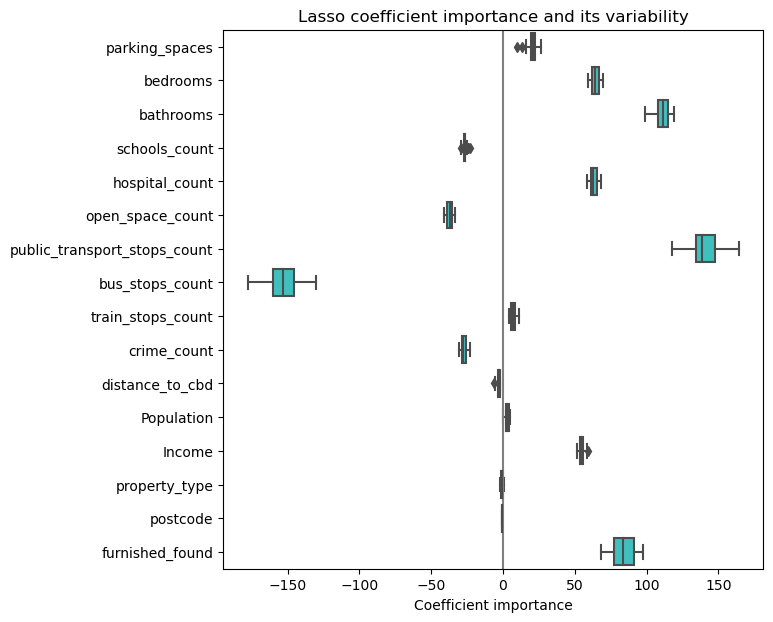

In [12]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold
import seaborn as sns
# this code adopts from online
# lasso coef visualization
def viz_linear_importance(model, X_feat, y):
    """Visualizes the linear importance of a model's features.

    Args:
        model: The model to evaluate.
        X_feat: The input data.
        y: The ground truth labels.
    """

  # Perform cross-validation to evaluate the model and obtain the model
  # coefficients for each fold.
    cv_model = cross_validate(
        model,
        X_feat,
        y,
        cv=RepeatedKFold(n_splits=5, n_repeats=5),
        return_estimator=True,
        n_jobs=2,
    )
    # model's coefficients
    coefs = pd.DataFrame(
        [model.coef_ for model in cv_model["estimator"]],
        columns=train_data.columns,
    )
    # visualization
    plt.figure(figsize=(9, 7))
    sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5)
    plt.axvline(x=0, color=".5")
    plt.xlabel("Coefficient importance")
    plt.title("Lasso coefficient importance and its variability")
    plt.subplots_adjust(left=0.3)
    plt.savefig("../plots/lasso_coef.png", dpi = 500)

viz_linear_importance(lin_reg, x_train, y_train)

In [13]:
train_data.columns

Index(['parking_spaces', 'bedrooms', 'bathrooms', 'schools_count',
       'hospital_count', 'open_space_count', 'public_transport_stops_count',
       'bus_stops_count', 'train_stops_count', 'crime_count',
       'distance_to_cbd', 'Population', 'Income', 'property_type', 'postcode',
       'furnished_found'],
      dtype='object')

<Figure size 800x800 with 0 Axes>

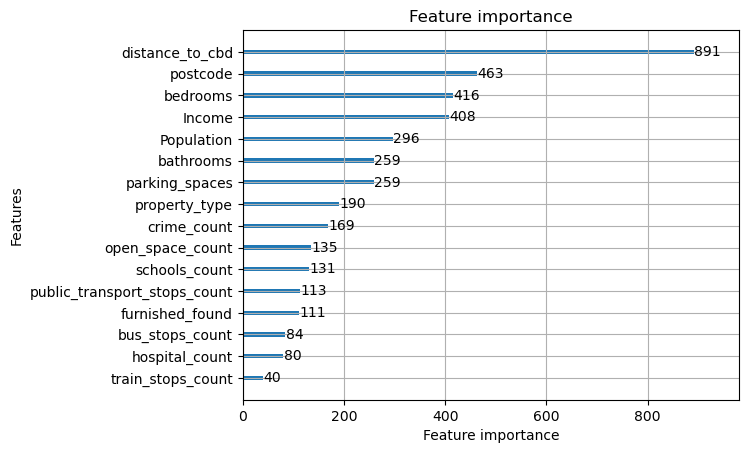

In [14]:
# feature importance for lgbm

import lightgbm
plt.figure(figsize = (8,8))
lightgbm.plot_importance(lgbm_reg)
# plt.yticks(ticks = None)
# plt.show()
plt.savefig("../plots/lgbm_coef.png", dpi = 600, bbox_inches = 'tight')

# Inference on 2026 

Input for preprocess_historical notebook

In [15]:
hist_2026 = pd.read_csv(f"{CURATED_DATA_DIR}/ready_for_inference_2026.csv")
training_data = pd.read_csv("../data/curated/real_estate_2023_train_x.csv")
training_data = fillin_missing_values(training_data, training_data)

# fill in missing values for 2026_projected real estate data based on 
# training_data: training set
# PIPELINE in 4 lines of code 
hist_2026 = fillin_missing_values(hist_2026, training_data, use_ref= True)
full_data = hist_2026.copy()
hist_2026 = hist_2026[features]
hist_2026[features] = full_pipeline.transform(hist_2026)

# INFERENCE 
prediction = lgbm_reg.predict(hist_2026)
full_data['prediction'] = prediction
full_data

,property_type,postcode,parking_spaces,bedrooms,bathrooms,furnished_found,schools_count,hospital_count,open_space_count,public_transport_stops_count,bus_stops_count,train_stops_count,crime_count,distance_to_cbd,Population,Income,prediction
0,Apartment / Unit / Flat,3000,1.0,2.0,2.0,False,1.0,14.0,53.0,32.0,9.0,1.0,4517.0,0.576701,54802.5,1391.0,847.103870
1,Apartment / Unit / Flat,3000,1.0,1.0,1.0,True,1.0,14.0,53.0,32.0,9.0,1.0,4517.0,0.823173,54802.5,1391.0,520.993492
2,Apartment / Unit / Flat,3000,1.0,2.0,1.0,False,1.0,14.0,53.0,32.0,9.0,1.0,4517.0,1.079214,54802.5,1391.0,640.278124
3,Apartment / Unit / Flat,3000,1.0,1.0,1.0,False,1.0,14.0,53.0,32.0,9.0,1.0,4517.0,0.532909,54802.5,1391.0,494.992944
4,House,3000,2.0,2.0,1.0,True,1.0,14.0,53.0,32.0,9.0,1.0,4517.0,0.041890,54802.5,1391.0,679.543647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11655,House,3996,1.0,2.0,1.0,True,1.0,0.0,0.0,0.0,0.0,0.0,411.0,113.217230,7348.0,1491.5,393.492377
11656,House,3996,1.0,3.0,1.0,True,1.0,0.0,0.0,0.0,0.0,0.0,411.0,112.200691,7348.0,1491.5,455.975629
11657,House,3996,2.0,3.0,2.0,False,1.0,0.0,0.0,0.0,0.0,0.0,411.0,112.105665,7348.0,1491.5,486.500690
11658,House,3996,2.0,3.0,1.0,False,1.0,0.0,0.0,0.0,0.0,0.0,411.0,113.037672,7348.0,1491.5,415.429274


In [16]:
# save predicted price in 2026
full_data.to_csv(f"{CURATED_DATA_DIR}/real_estate_2026_pred.csv", 
                 index = False)